# Improving the dollar-cost averaging strategy with price volatility analysis

## 1. Introduction

*What is Dollar-Cost Averaging (DCA)?*

SOME TEXT

In [221]:
import cpi
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.neighbors import KernelDensity
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()

%matplotlib inline

Let's set up the simulation. The simulated investors will make purchases for 2 years and consider the previous 2 years of weekly stock prices fluctuations to be relevant.

In [224]:
# Import the equities_toolkit.py
import equities_toolkit as etk

In [166]:
tickers = ['MSFT', 'ABBV', 'XOM', 'T', 'MMM']
colors = ['C2', 'C1', 'C0', 'C3', 'C4']

In [38]:
help(etk.Stocks_Composite)

Help on class Stocks_Composite in module equities_toolkit:

class Stocks_Composite(builtins.object)
 |  Stocks_Composite(tickers: list, **kwargs)
 |  
 |  Collection of stocks for analysis. The stock price history are downloaded
 |  a composite index created.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, tickers: list, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_price_histroy_index(self, date: datetime.datetime) -> int
 |  
 |  get_prices(self, date: datetime.datetime) -> dict
 |  
 |  get_weights(self) -> dict
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [22]:
end = datetime.today().date()
start = end + relativedelta(weeks=-104)

In [ ]:
sc = etk.Stocks_Composite(tickers, start=start, end=end, interval='1wk')

<Axes: xlabel='Date', ylabel='Close'>

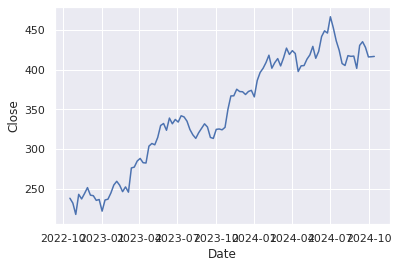

In [40]:
sns.lineplot(x=sc.stocks['MSFT'].price_history.Date, y=sc.stocks['MSFT'].price_history.Close)

<Axes: xlabel='Date', ylabel='Close'>

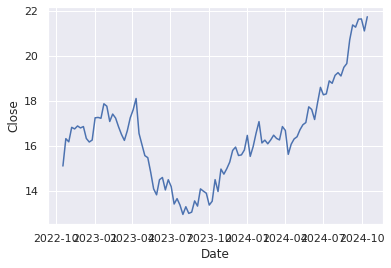

In [41]:
sns.lineplot(x=sc.stocks['T'].price_history.Date, y=sc.stocks['T'].price_history.Close)

<Axes: xlabel='Date', ylabel='Close'>

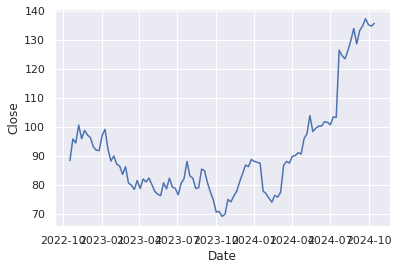

In [42]:
sns.lineplot(x=sc.stocks['MMM'].price_history.Date, y=sc.stocks['MMM'].price_history.Close)

<Axes: xlabel='Date', ylabel='Close'>

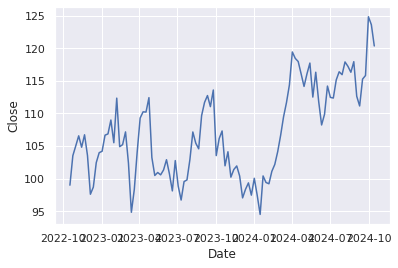

In [43]:
sns.lineplot(x=sc.stocks['XOM'].price_history.Date, y=sc.stocks['XOM'].price_history.Close)

<Axes: xlabel='Date', ylabel='Close'>

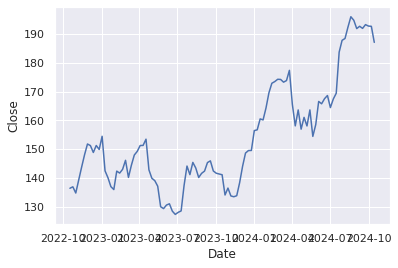

In [44]:
sns.lineplot(x=sc.stocks['ABBV'].price_history.Date, y=sc.stocks['ABBV'].price_history.Close)

In [62]:
dca_xom = sc.stocks['XOM'].price_history.iloc[:len(sc.stocks['XOM'].price_history):2].copy()

In [63]:
dca_xom.drop(columns=['Volume', 'Dividends'], inplace=True)
dca_xom['Cost'] = 500.0  # Amount to invest every 2 weeks

In [64]:
dca_xom['Cum_Cost'] = dca_xom.Cost.cumsum()  

In [65]:
dca_xom.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost
0,2022-10-17,99.004791,104.748499,500.0,500.0
2,2022-10-31,105.037109,111.130779,500.0,1000.0
4,2022-11-14,104.822006,111.015325,500.0,1500.0
6,2022-11-28,103.572899,109.692415,500.0,2000.0
8,2022-12-12,98.708191,104.862217,500.0,2500.0


In [67]:
dca_xom['Shares'] = dca_xom.Cost / dca_xom.Close
dca_xom['Cum_Shares'] = dca_xom.Shares.cumsum()

In [68]:
dca_xom.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares
0,2022-10-17,99.004791,104.748499,500.0,500.0,5.050261,5.050261
2,2022-10-31,105.037109,111.130779,500.0,1000.0,4.760222,9.810483
4,2022-11-14,104.822006,111.015325,500.0,1500.0,4.769991,14.580474
6,2022-11-28,103.572899,109.692415,500.0,2000.0,4.827518,19.407991
8,2022-12-12,98.708191,104.862217,500.0,2500.0,5.065436,24.473427


In [72]:
dca_xom['value']= dca_xom.apply(lambda x: x.Close * x.Cum_Shares, axis=1)

In [139]:
total_shares = dca_xom.Cum_Shares.max()

In [141]:
avg_pps = ((dca_xom.Shares/total_shares) * dca_xom.Close).sum()
avg_pps

106.77359806165717

In [143]:
dca_xom.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares,value,mrkr_size
0,2022-10-17,99.004791,104.748499,500.0,500.0,5.050261,5.050261,500.000000,10
2,2022-10-31,105.037109,111.130779,500.0,1000.0,4.760222,9.810483,1030.464779,10
4,2022-11-14,104.822006,111.015325,500.0,1500.0,4.769991,14.580474,1528.354513,10
6,2022-11-28,103.572899,109.692415,500.0,2000.0,4.827518,19.407991,2010.141936,10
8,2022-12-12,98.708191,104.862217,500.0,2500.0,5.065436,24.473427,2415.727726,10


In [144]:
dca_xom.Close.describe()

count     53.000000
mean     107.227701
std        7.136758
min       96.727768
25%      101.346634
50%      105.215408
75%      112.365364
max      124.830002
Name: Close, dtype: float64

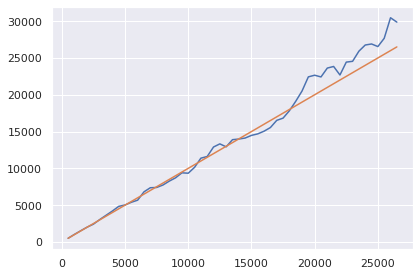

In [98]:
plt.plot(dca_xom.Cum_Cost, dca_xom.value)
plt.plot(dca_xom.Cum_Cost, dca_xom.Cum_Cost)
plt.tight_layout()
plt.show()

In [82]:
dca_gain = ((dca_xom.value.iloc[-1] / dca_xom.Cum_Cost.iloc[-1]) -1)

In [83]:
dca_gain

0.12715128701220846

In [88]:
dca_xom.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares,cps,value
0,2022-10-17,99.004791,104.748499,500.0,500.0,5.050261,5.050261,99.004791,500.000000
2,2022-10-31,105.037109,111.130779,500.0,1000.0,4.760222,9.810483,105.037109,1030.464779
4,2022-11-14,104.822006,111.015325,500.0,1500.0,4.769991,14.580474,104.822006,1528.354513
6,2022-11-28,103.572899,109.692415,500.0,2000.0,4.827518,19.407991,103.572899,2010.141936
8,2022-12-12,98.708191,104.862217,500.0,2500.0,5.065436,24.473427,98.708191,2415.727726


In [94]:
sc.stocks['XOM'].price_history.drop(columns=['Volume', 'Dividends'], inplace=True)

In [99]:
xom = sc.stocks['XOM'].price_history

In [96]:
# Save the data for tableau
xom.to_csv('xom_20221017-20241014.txt',index_label='week', sep=' ')
dca_xom.to_csv('dca_xom_20221017-20241014.txt', index_label='week', sep=' ')

In [130]:
dca_xom.Close.pct_change().sort_values().head()

86   -0.069504
50   -0.067601
18   -0.063504
28   -0.063184
38   -0.058835
Name: Close, dtype: float64

In [145]:
eg_purchase = dca_xom.loc[[48,50]]
eg_purchase

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares,value,mrkr_size
48,2023-09-18,111.046440,113.756676,500.0,12500.0,4.502621,119.998331,13325.387496,50
50,2023-10-02,103.539635,106.107337,500.0,13000.0,4.829069,124.827400,12924.583373,50


In [119]:
dca_xom['mrkr_size'] = 10

In [126]:
dca_xom.loc[[48,50], 'mrkr_size'] = 50

In [159]:
annotation_txt = [' 4.5 Shares', ' 4.8 Shares']

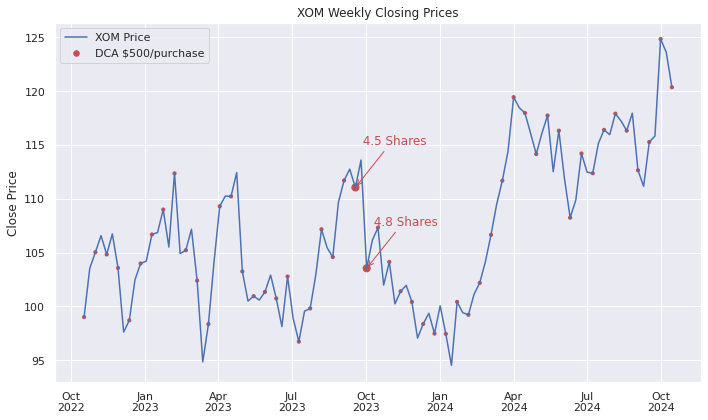

In [195]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(xom['Date'], xom['Close'], label='XOM Price', color='C0')
ax.scatter(dca_xom['Date'], dca_xom['Close'], dca_xom['mrkr_size'], label='DCA $500/purchase', color='C3', marker='o')

# Formatting the x-axis to show quarter ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Show month and year

# Add annotation
arrows = {'arrowstyle':'->', 'color': 'C3'}

for i in range(len(annotation_txt)):
    x = eg_purchase.Date.iloc[i]
    y = eg_purchase.Close.iloc[i]
    ax.annotate(annotation_txt[i], (x, y), xytext=(mdates.date2num(x)+4, y+4), arrowprops=arrows, color='C3')

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Close Price')
ax.set_title('XOM Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

## 2. Five Blue-Chip Stock Index Fund

DCA is commonly applied when investing in index or mutual funds because it lessens the burden on the investor to research each individual company. Index funds are great for passive investors and additionally offer some risk protection through diversification. I am going to evaluated a variation on applying DCA to an index fund by applying some analysis to the weekly returns of 5 blue-chip stocks that underly a simple index fund.

In [167]:
end = datetime.today().date()
start = end + relativedelta(weeks=-208)  # 4 years of price history 

In [226]:
bc5 = etk.Stocks_Composite(tickers, start=start, end=end, interval='1wk')

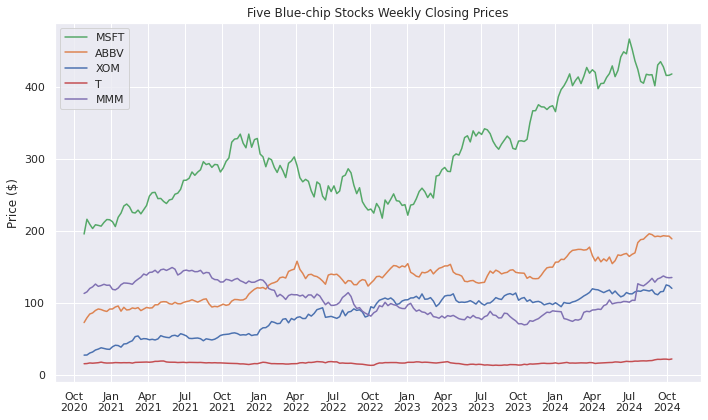

In [193]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(len(tickers)):
    date = bc5.stocks[tickers[i]].price_history.Date
    ax.plot(date, bc5.stocks[tickers[i]].price_history.Close, label=tickers[i], color=colors[i])

# Formatting the x-axis to show quarter ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Show month and year

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Price ($)')
ax.set_title('Five Blue-chip Stocks Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [182]:
bc5_weights = pd.DataFrame(bc5.weights, index=[0])

In [183]:
bc5_weights.loc[0] =  round(bc5_weights.loc[0] * 100, 2)

In [184]:
bc5_weights

,MSFT,ABBV,XOM,T,MMM
0,73.9,7.93,12.68,3.73,1.77


In [190]:
bc5_weights.to_csv('mcap_weights.txt', sep=' ', index=False)

Text(0, 0.5, 'Market Cap %')

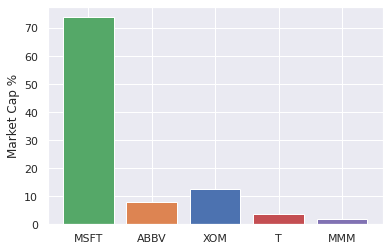

In [189]:
plt.bar(x=range(bc5_weights.shape[1]), height=bc5_weights.loc[0], color=colors, tick_label=bc5_weights.columns)
plt.ylabel('Market Cap %')

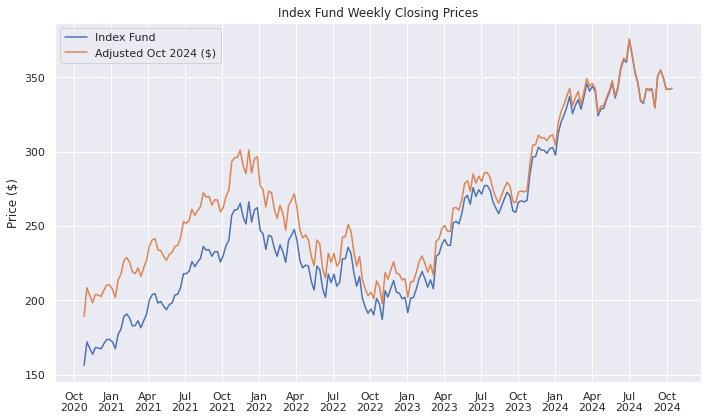

In [194]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(bc5.index.Date, bc5.index.Index, label='Index Fund', color='C0')
ax.plot(bc5.index.Date, bc5.index.Index_Adj, label='Adjusted Oct 2024 ($)', color='C1')

# Formatting the x-axis to show quarter ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Show month and year

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Price ($)')
ax.set_title('Index Fund Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Distribution of weekly returns from index fund stocks

Build kernel density estimate (kde) of weekly returns

In [200]:
bc5.stocks['MSFT'].price_history.head()

,Date,Close,Volume,Dividends,Inflation_Adj
0,2020-10-26,195.590851,193393800,0.00,236.838836
1,2020-11-02,216.118896,161978000,0.00,261.855920
2,2020-11-09,209.153778,158095900,0.00,253.416781
3,2020-11-16,203.241730,125116000,0.56,246.253571
4,2020-11-23,208.461639,95188300,0.00,252.578165


In [235]:
bc5.stocks['MSFT'].price_history.shape

(208, 5)

In [230]:
bw_bounds = (-2, 1)
params = {'bandwidth': np.logspace(bw_bounds[0], bw_bounds[1], 15)}

In [231]:
grid = GridSearchCV(
                KernelDensity(kernel='gaussian'),
                params,
                cv=ShuffleSplit(n_splits=5, test_size=0.20),
                n_jobs=-1
                )

In [257]:
tickers

['MSFT', 'ABBV', 'XOM', 'T', 'MMM']

In [258]:
X_msft = bc5.stocks['MSFT'].price_history.Inflation_Adj.loc[:106]
X_abbv = bc5.stocks['ABBV'].price_history.Inflation_Adj.loc[:106]
X_xom = bc5.stocks['XOM'].price_history.Inflation_Adj.loc[:106]
X_t = bc5.stocks['T'].price_history.Inflation_Adj.loc[:106]
X_mmm = bc5.stocks['MMM'].price_history.Inflation_Adj.loc[:106]

In [270]:
eg_pct_change = {}

In [272]:
eg_pct_change['Date'] = bc5.index.Date.loc[X_msft.index.values[-1]]

In [273]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7)}

In [266]:
X_msft = pd.DataFrame(X_msft.pct_change()*100)
X_abbv = pd.DataFrame(X_abbv.pct_change()*100)
X_xom = pd.DataFrame(X_xom.pct_change()*100)
X_t = pd.DataFrame(X_t.pct_change()*100)
X_mmm = pd.DataFrame(X_mmm.pct_change()*100)

In [268]:
X_msft.index.values[-1]

106

In [274]:
X_msft.tail()

,Inflation_Adj
102,-2.424864
103,5.932792
104,-2.581356
105,-6.138975
106,11.730351


In [280]:
X_msft.loc[X_msft.index.values[-1]]

Inflation_Adj    11.730351
Name: 106, dtype: float64

In [283]:
eg_pct_change['MSFT'] = X_msft.loc[X_msft.index.values[-1]][0]
eg_pct_change['ABBV'] = X_abbv.loc[X_abbv.index.values[-1]][0]
eg_pct_change['XOM'] = X_xom.loc[X_xom.index.values[-1]][0]
eg_pct_change['T'] = X_t.loc[X_t.index.values[-1]][0]
eg_pct_change['MMM'] = X_mmm.loc[X_mmm.index.values[-1]][0]

Save the last value and drop before training the kde

In [284]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247}

In [295]:
X_msft.drop(X_msft.tail(1).index, inplace=True)
X_abbv.drop(X_abbv.tail(1).index, inplace=True)
X_xom.drop(X_xom.tail(1).index, inplace=True)
X_t.drop(X_t.tail(1).index, inplace=True)
X_mmm.drop(X_mmm.tail(1).index, inplace=True)

In [297]:
print(X_msft.tail())
print(X_abbv.tail())

     Inflation_Adj
101       0.169013
102      -2.424864
103       5.932792
104      -2.581356
105      -6.138975
     Inflation_Adj
101       2.972483
102       3.012393
103       3.929193
104       0.374004
105      -1.578476


In [298]:
X_msft.dropna(inplace=True)
X_abbv.dropna(inplace=True)
X_xom.dropna(inplace=True)
X_t.dropna(inplace=True)
X_mmm.dropna(inplace=True)

In [303]:
X_msft.head()

,Inflation_Adj
1,10.562915
2,-3.222818
3,-2.826651
4,2.568326
5,-0.404209


In [305]:
eg_pct_change['MSFT_5ile'] = np.percentile(X_msft, 5)
eg_pct_change['ABBV_5ile'] = np.percentile(X_abbv, 5)
eg_pct_change['XOM_5ile'] = np.percentile(X_xom, 5)
eg_pct_change['T_5ile'] = np.percentile(X_t, 5)
eg_pct_change['MMM_5ile'] = np.percentile(X_mmm, 5)

In [306]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247,
 'MSFT_5ile': -5.711491982497396,
 'ABBV_5ile': -4.6347744216418585,
 'XOM_5ile': -6.247127820704899,
 'T_5ile': -4.458041289465437,
 'MMM_5ile': -5.530600016579948}

In [313]:
grid.fit(X_msft)
X_msft.sort_values(by='Inflation_Adj', inplace=True)
X_msft['msft_prob'] = grid.score_samples(X_msft)
X_msft['msft_prob'] = X_msft['msft_prob'].apply(np.exp)
eg_pct_change['MSFT_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['MSFT_5ile']])))
X_msft.rename(columns={'Inflation_Adj':'msft_wkly_rtrn'}, inplace=True)
X_msft.head()

,Inflation_Adj,msft_prob
84,-7.576489,-4.167611
98,-7.456671,-4.105140
62,-7.403813,-4.078353
105,-6.138975,-3.521255
95,-6.112513,-3.510497


In [325]:
np.exp(grid.score(pd.DataFrame([-7.576489])))

0.015489222640842168

In [329]:
eg_pct_change['MSFT_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['MSFT_5ile']])))

In [330]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247,
 'MSFT_5ile': -5.711491982497396,
 'ABBV_5ile': -4.6347744216418585,
 'XOM_5ile': -6.247127820704899,
 'T_5ile': -4.458041289465437,
 'MMM_5ile': -5.530600016579948,
 'MSFT_5ile_p': 0.03510917938037208}

In [254]:
X.shape

(104, 1)

In [249]:
y = grid.score_samples(X_sorted)

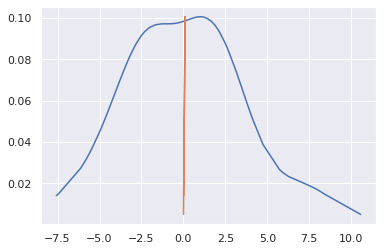

In [333]:
plt.plot(X_sorted, np.exp(y))
plt.scatter(eg_pct_change['MSFT_5ile'],eg_pct_change['MSFT_5ile_p'], color='C3')

In [307]:
X_sorted['prob'] = np.exp(y)

In [310]:
X_sorted.columns = ['msft_wkly_rtrn', 'prob']

In [311]:
X_sorted.head()

,msft_wkly_rtrn,prob
84,-7.576489,0.014022
98,-7.456671,0.014885
62,-7.403813,0.015274
95,-6.112513,0.027409
76,-5.771642,0.031941


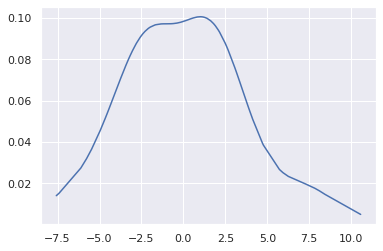

In [312]:
plt.plot(X_sorted.msft_wkly_rtrn, X_sorted.prob)